In [3]:
import os
import numpy as np
import wfdb
import matplotlib.pyplot as plt

In [1]:
def load_data(path):
    """Loads database file and returns ECG signal samples and fields list"""
    try:
        signals, fields = wfdb.rdsamp(path, channels=[1])
        ecg = signals[:,0]
        ecg = ecg.flatten()
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None


def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)


def rectify_signal(signal):
    return np.abs(signal)


def integrate_signal(signal, window_size):
    return np.convolve(signal, np.ones(window_size), mode="same")


def detect_changes_in_signal(signal, window_size, threshold=0.001, do_plot=False):
    if do_plot:
        plt.plot(signal[:signal.size - signal.size % window_size], color="#333F4B")

    changes = [
        (
            i,
            i + window_size - 1,
            np.sum(np.gradient(signal[i:i+window_size])) > threshold
        )
        for i in range(0, signal.size, window_size)
    ]

    if do_plot:
        for (base, end, rising) in changes:
            plt.axvspan(base, end, color="#0fa821" if rising else "#a80f30", alpha=0.5)

    return changes

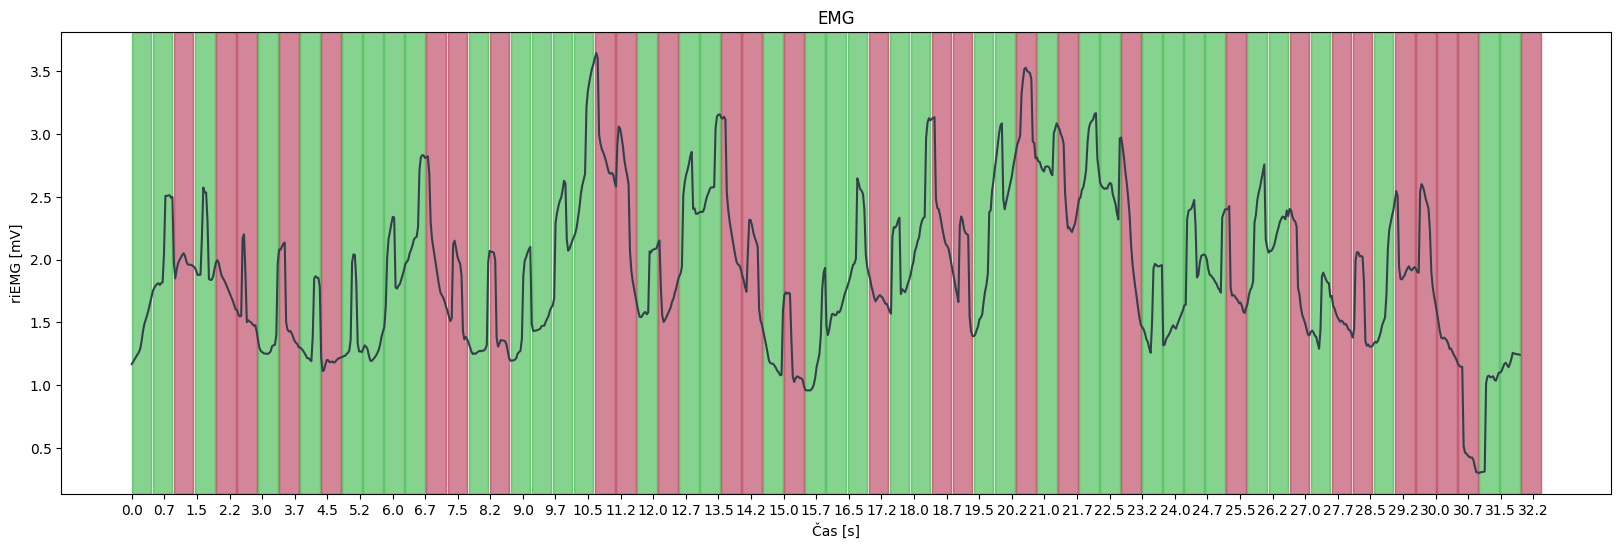

In [4]:
signal, signal_info = wfdb.rdsamp("Database/drive03")
signal = signal[:1000, 0]

rectified_signal = rectify_signal(signal)
integrated_signal = integrate_signal(rectified_signal, int(signal_info['fs']))

plt.figure(figsize=(20, 6))
plt.title("EMG")
plt.ylabel("riEMG [mV]")
plt.xlabel("Čas [s]")
plt.xticks(np.arange(0, len(signal), 60*12/signal_info['fs']), np.round(np.arange(0, len(signal), 60*12/signal_info['fs']) / signal_info['fs'], 1))

_ = detect_changes_in_signal(integrated_signal, int(signal_info['fs']/2), do_plot=True)
plt.show()

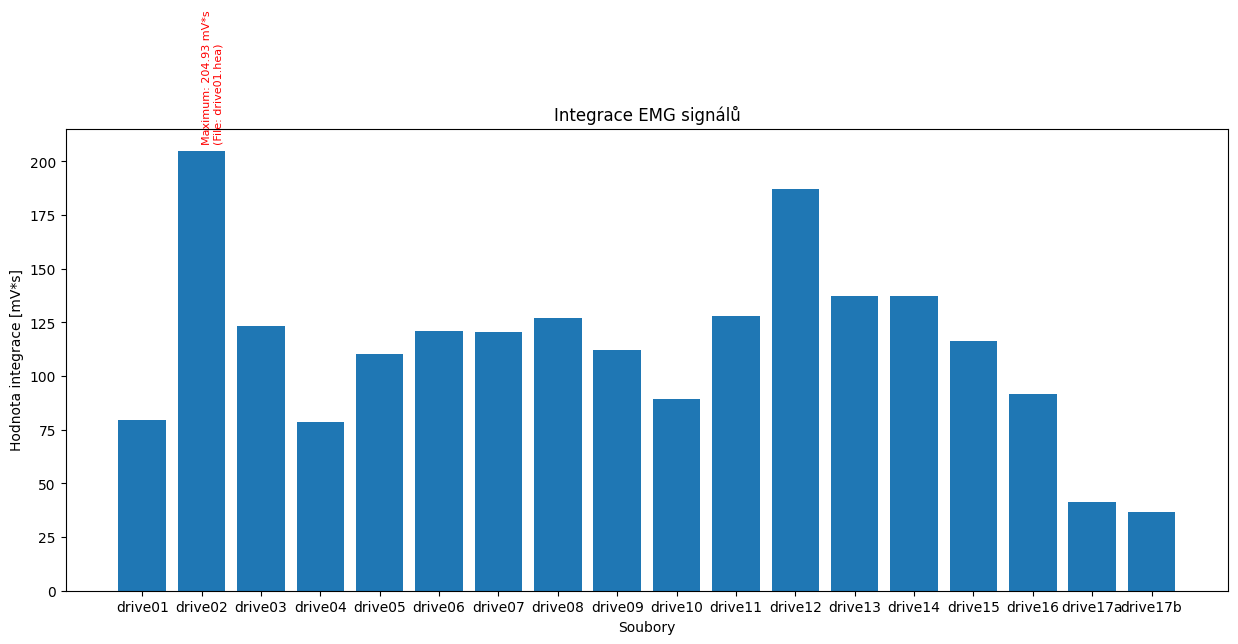

In [5]:

integrated_values = []

for file in os.listdir("Database"):
    if not file.endswith(".dat"):
        continue
    file = file[:-4]

    ecg, fields = wfdb.rdsamp(f"Database/{file}")
    ecg = ecg[:, 0]
    ecg = high_pass_filter(ecg, fields["fs"])
    window_size = int(fields['fs'])
    integrated_signal = np.zeros(len(ecg))
    integrated_signal = np.trapz(np.abs(ecg), dx=1/fields['fs'])
    min_signal_len = min([len(ecg) for ecg in os.listdir("Database") if ecg.endswith(".dat")])
    integrated_values.append(integrated_signal)

integrated_values = np.array(integrated_values)

max_integration_file = np.argmax(integrated_values)
max_integration_value = np.max(integrated_values)

plt.figure(figsize=(15, 6))
plt.title("Integrace EMG signálů")
plt.xlabel("Soubory")
plt.ylabel("Hodnota integrace [mV*s]")
plt.xticks(np.arange(len(integrated_values)), [f"{file[:-4]}" for file in os.listdir("Database") if file.endswith(".dat")][:len(integrated_values)])
plt.bar(np.arange(len(integrated_values)), integrated_values.flatten())
plt.text(max_integration_file, max_integration_value * 1.02, f"Maximum: {max_integration_value:.2f} mV*s\n(File: {os.listdir('Database')[max_integration_file]})", rotation=90, color="red", fontsize=8)
plt.show()